In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt
import seaborn as sns 

# deep learning
import cv2 
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
DATA_PATH = '/Users/anjalibharti/Downloads/archive/2020-02-14_InfraredSolarModules/InfraredSolarModules'
METADATA_PATH = os.path.join(DATA_PATH, 'module_metadata.json')

In [3]:
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(DATA_PATH, x))
df

,image_filepath,anomaly_class
0,/Users/anjalibharti/Downloads/archive/2020-02-...,Offline-Module
1,/Users/anjalibharti/Downloads/archive/2020-02-...,Offline-Module
2,/Users/anjalibharti/Downloads/archive/2020-02-...,Offline-Module
3,/Users/anjalibharti/Downloads/archive/2020-02-...,Offline-Module
4,/Users/anjalibharti/Downloads/archive/2020-02-...,Offline-Module
...,...,...
19995,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
19996,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
19997,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
19998,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly


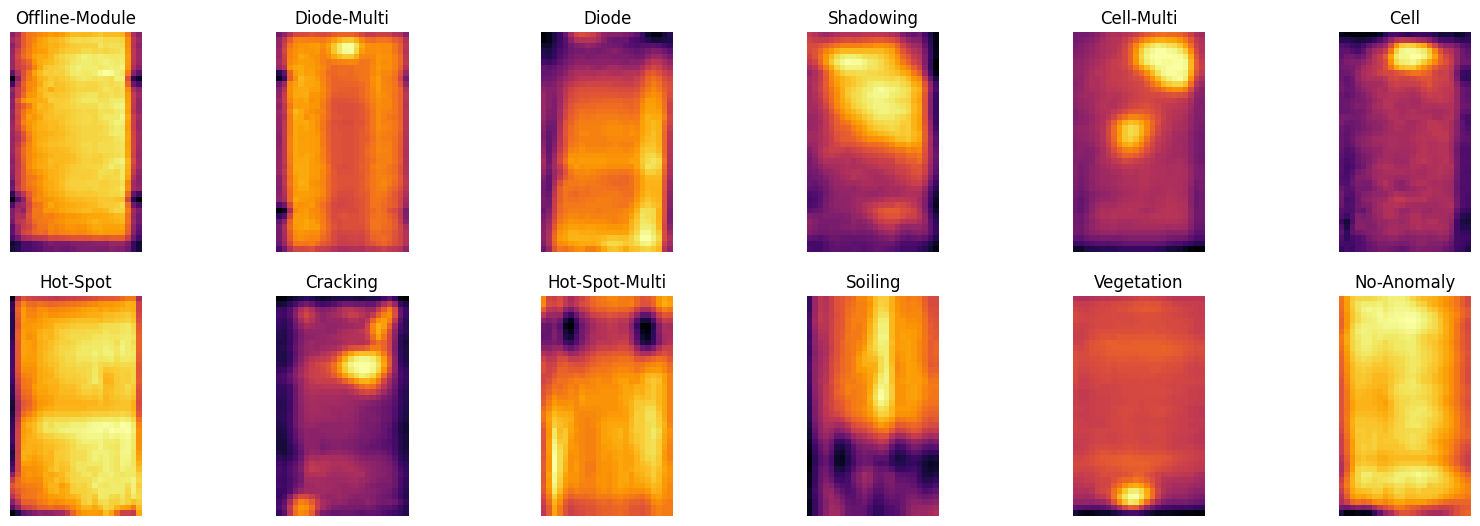

In [4]:
# Get unique anomaly classes
unique_classes = df['anomaly_class'].unique()

# Plot the sampled images
plt.figure(figsize=(20, 20))

for i, class_name in enumerate(unique_classes, start=1):
    # Sample one image for each class
    sample = df[df['anomaly_class'] == class_name].sample(n=1).iloc[0]
    
    image = cv2.imread(sample['image_filepath'], 0)
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='inferno')
    plt.title(class_name)
    plt.axis('off')

plt.show()

In [5]:
anomaly_df = df[df['anomaly_class'] != 'No-Anomaly']
anomaly_df.anomaly_class.value_counts()

anomaly_class
Cell              1877
Vegetation        1639
Diode             1499
Cell-Multi        1288
Shadowing         1056
Cracking           940
Offline-Module     827
Hot-Spot           249
Hot-Spot-Multi     246
Soiling            204
Diode-Multi        175
Name: count, dtype: int64

In [6]:
# Function to load and preprocess images
def load_and_preprocess_image(filepath):
    img = load_img(filepath, color_mode='grayscale', target_size=(40, 24))  # Adjust target size if necessary
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image to [0, 1]
    return img_array

# Define the augmentation layers
flip_layer = tf.keras.layers.RandomFlip('vertical')
resizing_layer = tf.keras.layers.Resizing(height=40, width=24)
rotation_layer = tf.keras.layers.RandomRotation(factor=0.3)

# def random_crop(image, fraction):
#     # Get the original image dimensions
#     original_shape = tf.shape(image)
#     height = original_shape[0]
#     width = original_shape[1]
    
#     # Calculate the new crop size
#     new_height = tf.cast(height * fraction, tf.int32)
#     new_width = tf.cast(width * fraction, tf.int32)
    
#     # Randomly crop the image
#     cropped_image = tf.image.random_crop(image, size=[new_height, new_width, original_shape[2]])
#     return cropped_image
    
# Function to apply augmentation
def apply_augmentation(img, label, output_dir, base_filename, img_count):
    augmented_imgs = []
    # Apply a series of augmentations and save them
    img_list = [
        (img, label),
        (flip_layer(img), label),
        (tf.image.flip_left_right(img), label),  # Additional horizontal flip
        (tf.image.adjust_brightness(img, delta=0.1), label),  # Adjust brightness
        # (tf.image.central_crop(img, central_fraction=0.8), label),  # Central crop
        (tf.image.adjust_contrast(img, contrast_factor=1.5), label),
        (resizing_layer(img), label),
        (rotation_layer(img), label),
        # (random_crop(img, fraction=1), label)
    ]
    for i, (aug_img, lbl) in enumerate(img_list):
        img_count += 1
        filename = f"{base_filename}_aug_{img_count}.jpg"
        filepath = os.path.join(output_dir, filename)
        aug_img_pil = array_to_img(aug_img)
        aug_img_pil.save(filepath)
        augmented_imgs.append((filepath, lbl))
    return augmented_imgs, img_count

In [7]:
# Directory where the augmented images will be saved
output_dir = '/Users/anjalibharti/Downloads/infrared_fold'  # Replace with your desired directory
os.makedirs(output_dir, exist_ok=True)

# Load and augment images
augmented_images = []
img_count = 0

for idx, row in anomaly_df.iterrows():
    img_path = row['image_filepath']
    label = row['anomaly_class']
    img_array = load_and_preprocess_image(img_path)
    base_filename = os.path.splitext(os.path.basename(img_path))[0]
    augmented_img, img_count = apply_augmentation(img_array, label, output_dir, base_filename, img_count)
    augmented_images.extend(augmented_img)

# Create a DataFrame
augmented_df = pd.DataFrame(augmented_images, columns=['image_filepath', 'anomaly_class'])

# Display the DataFrame
print(augmented_df.head())

                                      image_filepath   anomaly_class
0  /Users/anjalibharti/Downloads/infrared_fold/0_...  Offline-Module
1  /Users/anjalibharti/Downloads/infrared_fold/0_...  Offline-Module
2  /Users/anjalibharti/Downloads/infrared_fold/0_...  Offline-Module
3  /Users/anjalibharti/Downloads/infrared_fold/0_...  Offline-Module
4  /Users/anjalibharti/Downloads/infrared_fold/0_...  Offline-Module


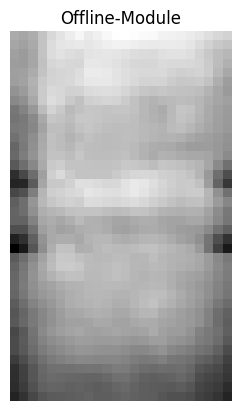

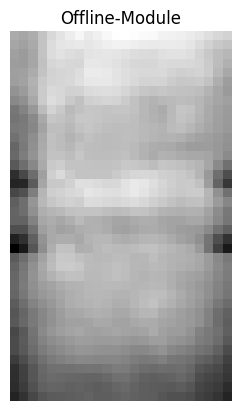

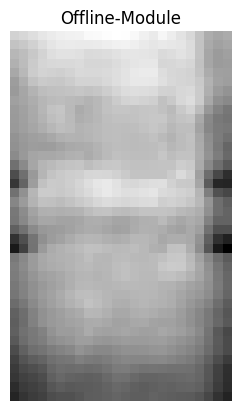

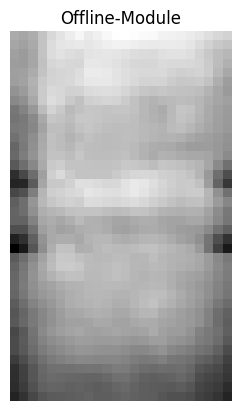

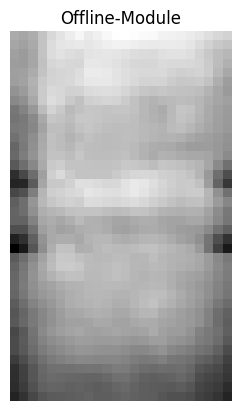

In [8]:
# Display the first few augmented images to verify
for img_path, lbl in augmented_images[:5]:
    img = load_img(img_path, color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(lbl)
    plt.axis('off')
    plt.show()

In [9]:
augmented_df.shape

(70000, 2)

In [10]:
no_anomaly_df = df[df['anomaly_class'] == 'No-Anomaly']
# sam_no_anomaly_df = no_anomaly_df.sample(n=1000, random_state=42)

In [11]:
new_index = pd.RangeIndex(start= 70000, stop= 80000, step=1)

# Set the new index to the DataFrame
# sam_no_anomaly_df.index = new_index
no_anomaly_df.index = new_index

In [12]:
no_anomaly_df.tail()

,image_filepath,anomaly_class
79995,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
79996,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
79997,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
79998,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
79999,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly


In [37]:
df_c = pd.concat([ augmented_df, no_anomaly_df], axis = 0)
df_c.head()

,image_filepath,anomaly_class
0,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module
1,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module
2,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module
3,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module
4,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module


In [38]:
im = cv2.imread(df_c['image_filepath'][0])
im = np.array(im)
print(im)

[[[169 169 169]
  [164 164 164]
  [171 171 171]
  ...
  [219 219 219]
  [212 212 212]
  [207 207 207]]

 [[164 164 164]
  [159 159 159]
  [168 168 168]
  ...
  [206 206 206]
  [197 197 197]
  [193 193 193]]

 [[158 158 158]
  [153 153 153]
  [164 164 164]
  ...
  [197 197 197]
  [187 187 187]
  [181 181 181]]

 ...

 [[ 46  46  46]
  [ 63  63  63]
  [ 85  85  85]
  ...
  [ 69  69  69]
  [ 65  65  65]
  [ 54  54  54]]

 [[ 45  45  45]
  [ 61  61  61]
  [ 81  81  81]
  ...
  [ 63  63  63]
  [ 59  59  59]
  [ 45  45  45]]

 [[ 35  35  35]
  [ 50  50  50]
  [ 70  70  70]
  ...
  [ 60  60  60]
  [ 53  53  53]
  [ 36  36  36]]]


In [39]:
unique_values = df_c.anomaly_class.value_counts()

In [40]:
df_c.anomaly_class.value_counts()

anomaly_class
Cell              13139
Vegetation        11473
Diode             10493
No-Anomaly        10000
Cell-Multi         9016
Shadowing          7392
Cracking           6580
Offline-Module     5789
Hot-Spot           1743
Hot-Spot-Multi     1722
Soiling            1428
Diode-Multi        1225
Name: count, dtype: int64

In [41]:
df_c.anomaly_class.value_counts()*100/len(df_c)

anomaly_class
Cell              16.42375
Vegetation        14.34125
Diode             13.11625
No-Anomaly        12.50000
Cell-Multi        11.27000
Shadowing          9.24000
Cracking           8.22500
Offline-Module     7.23625
Hot-Spot           2.17875
Hot-Spot-Multi     2.15250
Soiling            1.78500
Diode-Multi        1.53125
Name: count, dtype: float64

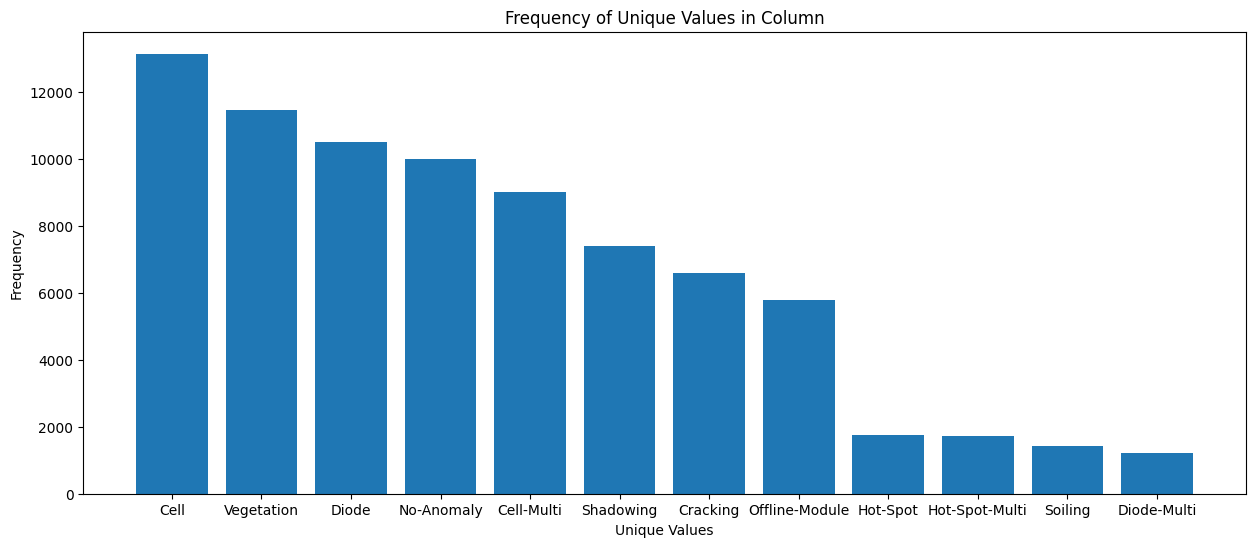

In [42]:
# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the bar chart
plt.bar(unique_values.index, unique_values.values)

# Set labels and title

plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Column')

# Show the plot
plt.show()

In [43]:
df_c = df_c.query('anomaly_class != ("Hot-Spot", "Hot-Spot-Multi")')
# df_c = df_c.query('anomaly_class != ("Soiling", "Diode-Multi")')
df_c

,image_filepath,anomaly_class
0,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module
1,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module
2,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module
3,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module
4,/Users/anjalibharti/Downloads/infrared_fold/0_...,Offline-Module
...,...,...
79995,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
79996,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
79997,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly
79998,/Users/anjalibharti/Downloads/archive/2020-02-...,No-Anomaly


In [44]:
df_c.anomaly_class.value_counts()

anomaly_class
Cell              13139
Vegetation        11473
Diode             10493
No-Anomaly        10000
Cell-Multi         9016
Shadowing          7392
Cracking           6580
Offline-Module     5789
Soiling            1428
Diode-Multi        1225
Name: count, dtype: int64

In [45]:
def load_and_preprocess_image(image_path, target_size=(40, 24)):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        if image is None:
            raise ValueError(f"Image not found or cannot be loaded: {image_path}")
        image = cv2.resize(image, target_size)  # Resize image
        image = np.expand_dims(image, axis=-1)  # Add channel dimension
        image = image / 255.0  # Normalize to [0, 1]
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

train = []
labels = []

for idx, row in df_c.iterrows():
    image_filepath = row['image_filepath']
    label = row['anomaly_class']
    processed_image = load_and_preprocess_image(image_filepath)
    if processed_image is not None:  # Only add if processing was successful
        train.append(processed_image)
        labels.append(label)

In [46]:
len(train)

76535

In [47]:
train = np.array(train)
labels = np.array(labels)
print(f'Train shape: {train.shape}')
print(f'Labels shape: {labels.shape}')

Train shape: (76535, 24, 40, 1)
Labels shape: (76535,)


In [48]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [49]:
labels

array([6, 6, 6, ..., 5, 5, 5])

In [50]:
X_train, X_temp, y_train, y_temp = train_test_split(train, labels, test_size=0.4, random_state= 3, stratify=labels)

# Second split: val and test from temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state= 3, stratify=y_temp)

In [51]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation

# # Filter the DataFrame for labels other than 'No-Anomaly'
# anomaly_df = df[df['anomaly_class'] != 'No-Anomaly']

# # Function to load and preprocess images
# def load_and_preprocess_image(filepath):
#     img = load_img(filepath, color_mode='grayscale', target_size=(40, 24))  # Adjust target size if necessary
#     img_array = img_to_array(img)
#     img_array = img_array / 255.0  # Normalize the image to [0, 1]
#     return img_array

# # Define augmentation layers
# resizing_layer = Resizing(height=40, width=24)
# flip_layer = RandomFlip(mode="horizontal_and_vertical")
# rotation_layer = RandomRotation(factor=0.3)

# # Function to apply augmentation
# def apply_augmentation(img):
#     augmented_imgs = []
#     augmented_imgs.append(flip_layer(img))
#     augmented_imgs.append(tf.image.flip_left_right(img))  # Additional horizontal flip
#     augmented_imgs.append(tf.image.adjust_brightness(img, delta=0.1))  # Adjust brightness
#     augmented_imgs.append(tf.image.central_crop(img, central_fraction=0.8))  # Central crop
#     augmented_imgs.append(resizing_layer(img))
#     augmented_imgs.append(rotation_layer(img))
#     return augmented_imgs

# # Number of augmented images to generate per original image
# num_augmented_images = 5

# # Load and augment images
# augmented_images = []

# for idx, row in anomaly_df.iterrows():
#     img_path = row['image_filepath']
#     img_array = load_and_preprocess_image(img_path)
#     augmented_img_list = apply_augmentation(img_array)
#     for augmented_img in augmented_img_list:
#         augmented_images.append(augmented_img.numpy())

# # Convert to numpy array for easier handling
# augmented_images = np.array(augmented_images)

# # Display some augmented images
# def plot_images(images, num_images=25):
#     plt.figure(figsize=(10, 10))
#     for i in range(num_images):
#         plt.subplot(5, 5, i + 1)  # Create a 5x5 grid of subplots
#         plt.imshow(images[i].squeeze(), cmap='gray')  # Display the image in grayscale
#         plt.axis('off')
#     plt.show()

# # Plot 25 augmented images
# plot_images(augmented_images, num_images=25)

# # Check the length of augmented images
# print(f"Total number of augmented images: {len(augmented_images)}")


In [52]:
X_train.shape

(45921, 24, 40, 1)

In [53]:
model = Sequential()
    # First Conv2D layer with 32 filters and MaxPooling2D
model.add(Conv2D(32, (3, 3),strides = 1 , padding = 'same', activation='relu', input_shape= (40, 24, 1) ))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides = 2 , padding = 'same'))
    
    
#     # Second Conv2D layer with 64 filters and MaxPooling2D
model.add(Conv2D(64, (3, 3), padding = 'same',strides = 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2),strides = 2 , padding = 'same'))

model.add(Conv2D(64, (3, 3), padding = 'same',strides = 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2),strides = 2 , padding = 'same'))

    # Flatten the output
model.add(Flatten())

    # First Dense layer with 128 neurons
model.add(Dense(128, activation='relu')) #,kernel_regularizer=regularizers.l2(0.01)
model.add(Dropout(0.5))
    # Second Dense layer with 64 neurons
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
    # Output layer with `num_classes` neurons
model.add(Dense(10, activation='softmax'))
    
adam = Adam(learning_rate=0.001)
    # Compile the model
model.compile(optimizer= adam,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 40, 24, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 6, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,298 (735.54 KB)

 Trainable params: 187,978 (734.29 KB)

 Non-trainable params: 320 (1.25 KB)

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    verbose=2,
    # callbacks=[early_stopping],  # Include the callback in a list
    validation_data=(X_val, y_val),
    validation_freq=1
)

Epoch 1/50
1436/1436 - 34s - 23ms/step - accuracy: 0.3957 - loss: 1.6636 - val_accuracy: 0.3977 - val_loss: 2.9863
Epoch 2/50
1436/1436 - 32s - 23ms/step - accuracy: 0.4922 - loss: 1.3882 - val_accuracy: 0.5621 - val_loss: 1.2096
Epoch 3/50
1436/1436 - 33s - 23ms/step - accuracy: 0.5358 - loss: 1.2753 - val_accuracy: 0.5571 - val_loss: 1.2468
Epoch 4/50
1436/1436 - 37s - 26ms/step - accuracy: 0.5613 - loss: 1.2055 - val_accuracy: 0.5890 - val_loss: 1.1087
Epoch 5/50
1436/1436 - 36s - 25ms/step - accuracy: 0.5818 - loss: 1.1464 - val_accuracy: 0.6251 - val_loss: 1.0247
Epoch 6/50
1436/1436 - 36s - 25ms/step - accuracy: 0.6013 - loss: 1.1017 - val_accuracy: 0.6084 - val_loss: 1.0371
Epoch 7/50
1436/1436 - 37s - 26ms/step - accuracy: 0.6166 - loss: 1.0611 - val_accuracy: 0.6473 - val_loss: 0.9694
Epoch 8/50
1436/1436 - 38s - 26ms/step - accuracy: 0.6231 - loss: 1.0392 - val_accuracy: 0.6061 - val_loss: 1.1160
Epoch 9/50
1436/1436 - 37s - 26ms/step - accuracy: 0.6388 - loss: 0.9939 - val_a

In [56]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8044 - loss: 0.6620
Test Accuracy: 0.81


In [57]:
y_pred = model.predict(X_test)

479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [58]:
y_pred = np.argmax(y_pred, axis = 1)

In [59]:
y_pred

array([2, 0, 5, ..., 7, 3, 9])

In [60]:
classes = ['Cell', 'Vegetation', 'Diode', 'No-Anomaly', 'Cell-Multi', 'Shadowing', 'Cracking', 'Offline-Module', 'Soiling', 'Diode-Multi']

# Ensure that the number of classes matches the length of the classes list
assert len(set(y_test)) <= len(classes), "Number of unique labels in y_true must be less than or equal to the length of the classes list."
assert len(set(y_pred)) <= len(classes), "Number of unique labels in y_pred must be less than or equal to the length of the classes list."

# Calculate precision, recall, F1 score
report = classification_report(y_test, y_pred, target_names=classes[:len(set(y_test))], output_dict=True)

# Convert the classification report to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Print the classification report as a table
print("Classification Report:")
print(report_df[['precision', 'recall', 'f1-score']].round(2))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes[:len(set(y_test))], yticklabels=classes[:len(set(y_test))])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
                precision  recall  f1-score
Cell                 0.71    0.83      0.76
Vegetation           0.62    0.69      0.66
Diode                0.91    0.64      0.75
No-Anomaly           0.89    0.95      0.92
Cell-Multi           0.96    0.38      0.55
Shadowing            1.00    1.00      1.00
Cracking             0.83    0.83      0.83
Offline-Module       0.82    0.83      0.83
Soiling              0.76    0.50      0.61
Diode-Multi          0.80    0.74      0.77
accuracy             0.81    0.81      0.81
macro avg            0.83    0.74      0.77
weighted avg         0.82    0.81      0.81


NameError: name 'sns' is not defined

<Figure size 1200x1000 with 0 Axes>